In [1]:
import tika
from tika import parser
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
topics = 5

In [3]:
tika.initVM()
parsed = parser.from_file('article1.pdf')
metadados = parsed["metadata"]
texto = parsed["content"]

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [6]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [11]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [23]:
nlp = spacy.load('en', disable=['parser', 'ner'])
mallet_path = 'mallet-2.0.8/bin/mallet' 

data = split_pdf(texto)
# print(data)

data = first_clear(data)
# print(data)

data = list(sent_to_words(data))

# Remove Stop Words
data_words_nostops = remove_stopwords(data)

aggregate = {}
list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]

for i in range(0, len(list_pos)):
    l = []
    data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )

    bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_filtered)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                            update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)
    
    l.append(list_pos[i])
    l.append(data_lemmatized)
    l.append(id2word)
    l.append(corpus)
    l.append(lda_model)
    l.append(ldamallet)
    aggregate[i] = l

# Tópicos apenas levando em conta os Substantivos

In [24]:
pprint(aggregate[0][4].print_topics())
doc_lda = aggregate[0][4][aggregate[0][3]]

[(0,
  '0.079*"corpus" + 0.057*"network" + 0.047*"expert" + 0.033*"keyphrase" + '
  '0.032*"user" + 0.027*"extraction" + 0.025*"map" + 0.024*"datum" + '
  '0.024*"interface" + 0.024*"node"'),
 (1,
  '0.118*"bentham" + 0.048*"humanity" + 0.033*"access" + 0.032*"context" + '
  '0.018*"image" + 0.017*"feedback" + 0.017*"similarity" + 0.014*"problem" + '
  '0.014*"cluster" + 0.014*"tim"'),
 (2,
  '0.059*"evaluation" + 0.058*"page" + 0.041*"mention" + 0.034*"interest" + '
  '0.027*"mining" + 0.026*"document" + 0.020*"notion" + 0.019*"processing" + '
  '0.018*"figure" + 0.018*"lexical"'),
 (3,
  '0.098*"term" + 0.078*"journal" + 0.053*"result" + 0.041*"task" + '
  '0.031*"word" + 0.019*"source" + 0.017*"navigation" + 0.016*"model" + '
  '0.014*"type" + 0.014*"thierry"'),
 (4,
  '0.085*"concept" + 0.033*"information" + 0.026*"structure" + 0.026*"comment" '
  '+ 0.019*"tool" + 0.018*"visualization" + 0.018*"number" + '
  '0.017*"clustering" + 0.016*"system" + 0.014*"caus"')]


In [25]:
print('\nPerplexity: ', aggregate[0][4].log_perplexity(aggregate[0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[0][4], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.393179894539596

Coherence Score:  0.839945785279966


In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[0][4], aggregate[0][3], aggregate[0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.266750 -0.009439       1        1  37.965618
2     -0.080128 -0.191845       2        1  16.436913
1     -0.064588  0.061475       3        1  15.901100
3     -0.065314  0.110978       4        1  15.438316
4     -0.056720  0.028831       5        1  14.258048, topic_info=    Category        Freq        Term       Total  loglift  logprob
1    Default   79.000000     bentham   79.000000  30.0000  30.0000
436  Default   64.000000        term   64.000000  29.0000  29.0000
2    Default  127.000000      corpus  127.000000  28.0000  28.0000
3    Default   51.000000     concept   51.000000  27.0000  27.0000
36   Default   51.000000     journal   51.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
166   Topic5    2.309091       topic    2.990738   1.6892  -5.5622
575   Topic5    3.808530        weed    4.994205   1.6768  -5.0618
576   Topic5    3.808501        weir    4.994205   1.6768  -5.0618
494   Topic5    2.681019    software    3.878739   1.5785  -5.4128
899   Topic5    3.113689  linguistic   19.136660   0.1321  -5.2632

[197 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7         3  0.952055       access
180       3  0.884063     analysis
493       1  0.912524  application
196       2  0.908322     approach
354       4  0.578432       approx
...     ...       ...          ...
447       4  0.847133          web
575       5  0.800928         weed
576       5  0.800928         weir
349       4  0.946769         word
109       1  0.995694         work

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

In [27]:
pprint(aggregate[0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[0][5], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.072*"node" + 0.071*"concept" + 0.047*"document" + 0.046*"mention" + '
  '0.043*"dbpedia" + 0.043*"access" + 0.043*"humanity" + 0.031*"entity" + '
  '0.024*"list" + 0.020*"type"'),
 (1,
  '0.115*"term" + 0.064*"text" + 0.051*"tool" + 0.041*"context" + '
  '0.036*"search" + 0.034*"mining" + 0.025*"manuscript" + 0.024*"evaluation" + '
  '0.024*"figure" + 0.023*"content"'),
 (2,
  '0.120*"network" + 0.056*"map" + 0.043*"datum" + 0.039*"page" + '
  '0.037*"result" + 0.031*"interest" + 0.031*"information" + 0.027*"domain" + '
  '0.027*"interface" + 0.021*"file"'),
 (3,
  '0.143*"bentham" + 0.139*"corpus" + 0.071*"journal" + 0.020*"word" + '
  '0.017*"platform" + 0.017*"cluster" + 0.017*"folio" + 0.016*"task" + '
  '0.016*"language" + 0.015*"technology"'),
 (4,
  '0.059*"expert" + 0.052*"work" + 0.049*"keyphrase" + 0.041*"corpus" + '
  '0.039*"extraction" + 0.036*"user" + 0.033*"project" + 0.020*"year" + '
  '0.019*"transcription" + 0.018*"set"')]

Coherence Score:  0.84497398116600

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[0][2], corpus=aggregate[0][3], texts=aggregate[0][1], start=2, limit=40, step=6)


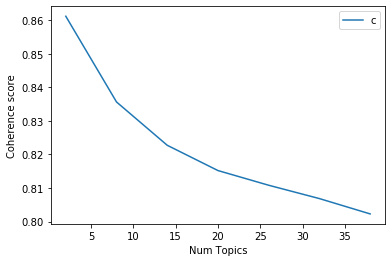

In [29]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [30]:
pprint(aggregate[1][4].print_topics())
doc_lda = aggregate[1][4][aggregate[1][3]]

[(0,
  '0.160*"open" + 0.035*"heiden" + 0.024*"variant" + 0.024*"configurable" + '
  '0.024*"key" + 0.019*"single" + 0.018*"critical" + 0.017*"certain" + '
  '0.017*"kim" + 0.016*"external"'),
 (1,
  '0.209*"digital" + 0.066*"relate" + 0.061*"new" + 0.060*"different" + '
  '0.043*"large" + 0.042*"available" + 0.031*"important" + 0.011*"complete" + '
  '0.010*"multi" + 0.009*"overestimate"'),
 (2,
  '0.393*"possible" + 0.045*"navigable" + 0.043*"useful" + 0.033*"first" + '
  '0.028*"several" + 0.025*"textual" + 0.018*"small" + 0.015*"specific" + '
  '0.014*"many" + 0.012*"preliminary"'),
 (3,
  '0.068*"international" + 0.044*"semantic" + 0.032*"distributional" + '
  '0.031*"computational" + 0.030*"annotate" + 0.027*"basic" + 0.027*"second" + '
  '0.023*"full" + 0.020*"melissa" + 0.016*"main"'),
 (4,
  '0.430*"general" + 0.091*"issn" + 0.028*"relevant" + 0.028*"jeremy" + '
  '0.019*"potential" + 0.018*"similar" + 0.015*"navigate" + 0.013*"high" + '
  '0.012*"automatic" + 0.009*"optimal"'

In [31]:
print('\nPerplexity: ', aggregate[1][4].log_perplexity(aggregate[1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[1][4], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.480304763444646

Coherence Score:  0.8416410295365173


In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[1][4], aggregate[1][3], aggregate[1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.260274  0.144798       1        1  25.928284
3     -0.019447 -0.133503       2        1  19.921959
4     -0.216922  0.197150       3        1  19.552231
0     -0.012246 -0.089540       4        1  17.417597
1     -0.011659 -0.118905       5        1  17.179930, topic_info=    Category       Freq          Term      Total  loglift  logprob
65   Default  67.000000       general  67.000000  30.0000  30.0000
79   Default  81.000000      possible  81.000000  29.0000  29.0000
8    Default  29.000000       digital  29.000000  28.0000  28.0000
2    Default  22.000000          open  22.000000  27.0000  27.0000
44   Default  14.000000          issn  14.000000  26.0000  26.0000
..       ...        ...           ...        ...      ...      ...
52    Topic5   0.174151          kind   0.901054   0.1178  -6.6685
54    Topic5   0.174151        active   0.901054   0.1178  -6.6685
275   Topic5   0.174382        neural   1.895650  -0.6246  -6.6672
277   Topic5   0.174382   substantive   1.895650  -0.6246  -6.6672
266   Topic5   0.174382  perspektiven   1.895650  -0.6246  -6.6672

[204 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
53        2  0.709617        able
255       4  0.955498    academic
207       2  0.937521  accessible
238       5  0.552405  additional
110       2  0.933206    annotate
...     ...       ...         ...
237       4  0.714343      visual
182       3  0.845657      weakly
59        5  0.632538       whole
243       4  0.562665      yellow
267       2  0.516500  zahlenwerk

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [33]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[1][5], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.092*"annotate" + 0.067*"textual" + 0.067*"jeremy" + '
  '0.050*"distributional" + 0.042*"high" + 0.034*"full" + 0.034*"private" + '
  '0.025*"precise" + 0.025*"navigate" + 0.025*"marginal"'),
 (1,
  '0.296*"digital" + 0.096*"relate" + 0.074*"general" + 0.037*"potential" + '
  '0.037*"single" + 0.030*"final" + 0.030*"great" + 0.022*"common" + '
  '0.015*"archive" + 0.015*"present"'),
 (2,
  '0.113*"open" + 0.113*"navigable" + 0.089*"relevant" + 0.056*"main" + '
  '0.056*"variant" + 0.040*"basic" + 0.032*"unpublished" + 0.024*"optimal" + '
  '0.024*"historical" + 0.024*"kim"'),
 (3,
  '0.115*"open" + 0.061*"international" + 0.054*"specific" + 0.054*"small" + '
  '0.041*"important" + 0.034*"frequent" + 0.027*"conceptual" + 0.027*"public" '
  '+ 0.027*"complete" + 0.027*"similar"'),
 (4,
  '0.211*"issn" + 0.075*"large" + 0.060*"semantic" + 0.045*"configurable" + '
  '0.045*"detail" + 0.030*"automatic" + 0.030*"computational" + 0.030*"heiden" '
  '+ 0.030*"political" + 0.023*"meli

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[1][2], corpus=aggregate[1][3], texts=aggregate[1][1], start=2, limit=40, step=6)


In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [36]:
pprint(aggregate[2][4].print_topics())
doc_lda = aggregate[2][4][aggregate[2][3]]

[(0,
  '0.091*"bentham" + 0.073*"term" + 0.025*"information" + 0.024*"document" + '
  '0.018*"processing" + 0.017*"general" + 0.017*"structure" + 0.016*"useful" + '
  '0.013*"tool" + 0.010*"cluster"'),
 (1,
  '0.053*"network" + 0.043*"expert" + 0.033*"keyphrase" + 0.031*"user" + '
  '0.029*"page" + 0.026*"extraction" + 0.024*"interface" + 0.023*"datum" + '
  '0.023*"map" + 0.019*"mention"'),
 (2,
  '0.133*"corpus" + 0.036*"open" + 0.027*"interest" + 0.026*"access" + '
  '0.013*"navigation" + 0.013*"number" + 0.012*"discussion" + 0.011*"problem" '
  '+ 0.010*"study" + 0.009*"tim"'),
 (3,
  '0.056*"journal" + 0.054*"concept" + 0.037*"result" + 0.033*"humanity" + '
  '0.029*"task" + 0.029*"issn" + 0.020*"context" + 0.017*"text" + '
  '0.015*"international" + 0.015*"comment"'),
 (4,
  '0.056*"evaluation" + 0.050*"digital" + 0.044*"work" + 0.042*"node" + '
  '0.037*"lexical" + 0.025*"mining" + 0.023*"possible" + 0.019*"navigable" + '
  '0.014*"similarity" + 0.013*"feedback"')]


In [37]:
print('\nPerplexity: ', aggregate[2][4].log_perplexity(aggregate[2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[2][4], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.853907453788004

Coherence Score:  0.8416631267426455


In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[2][4], aggregate[2][3], aggregate[2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.242846  0.000431       1        1  31.313425
3     -0.065095 -0.153224       2        1  19.227301
0     -0.055063  0.007864       3        1  17.685968
2     -0.055576  0.007014       4        1  17.159313
4     -0.067112  0.137914       5        1  14.613983, topic_info=     Category        Freq         Term       Total  loglift  logprob
2     Default  115.000000       corpus  115.000000  30.0000  30.0000
1     Default   81.000000      bentham   81.000000  29.0000  29.0000
570   Default   65.000000         term   65.000000  28.0000  28.0000
100   Default   83.000000      network   83.000000  27.0000  27.0000
43    Default   54.000000      journal   54.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
270    Topic5    3.136041   experiment    4.786366   1.5004  -5.4540
269    Topic5    2.135368  preliminary    3.230057   1.5093  -5.8384
1068   Topic5    6.248381          url   40.030098   0.0659  -4.7647
1107   Topic5    3.830971   conference   30.132610  -0.1393  -5.2539
1106   Topic5    2.770863   proceeding   24.212036  -0.2445  -5.5778

[212 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
10        4  0.966999         access
249       3  0.881762       analysis
276       5  0.902669       approach
180       4  0.677670      automatic
894       1  0.851103          basic
...     ...       ...            ...
561       1  0.912859  visualization
583       3  0.876122            web
628       4  0.900366   wikification
465       1  0.963023           word
142       5  0.982028           work

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])

In [39]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[2][5], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.092*"annotate" + 0.067*"textual" + 0.067*"jeremy" + '
  '0.050*"distributional" + 0.042*"high" + 0.034*"full" + 0.034*"private" + '
  '0.025*"precise" + 0.025*"navigate" + 0.025*"marginal"'),
 (1,
  '0.296*"digital" + 0.096*"relate" + 0.074*"general" + 0.037*"potential" + '
  '0.037*"single" + 0.030*"final" + 0.030*"great" + 0.022*"common" + '
  '0.015*"archive" + 0.015*"present"'),
 (2,
  '0.113*"open" + 0.113*"navigable" + 0.089*"relevant" + 0.056*"main" + '
  '0.056*"variant" + 0.040*"basic" + 0.032*"unpublished" + 0.024*"optimal" + '
  '0.024*"historical" + 0.024*"kim"'),
 (3,
  '0.115*"open" + 0.061*"international" + 0.054*"specific" + 0.054*"small" + '
  '0.041*"important" + 0.034*"frequent" + 0.027*"conceptual" + 0.027*"public" '
  '+ 0.027*"complete" + 0.027*"similar"'),
 (4,
  '0.211*"issn" + 0.075*"large" + 0.060*"semantic" + 0.045*"configurable" + '
  '0.045*"detail" + 0.030*"automatic" + 0.030*"computational" + 0.030*"heiden" '
  '+ 0.030*"political" + 0.023*"meli

In [40]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[2][2], corpus=aggregate[2][3], texts=aggregate[2][1], start=2, limit=40, step=6)


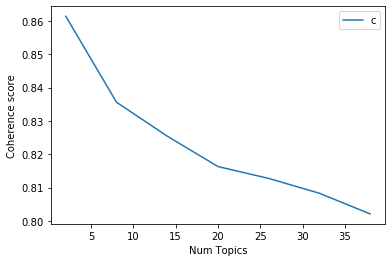

In [41]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()